In [56]:
import numpy as np
from scipy import ndimage, fft, stats
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread

In [57]:
PLOT_RESULTS = True
RADIUS = 30
STD = 5
DPI=120

## 1.1 Fourier transformation

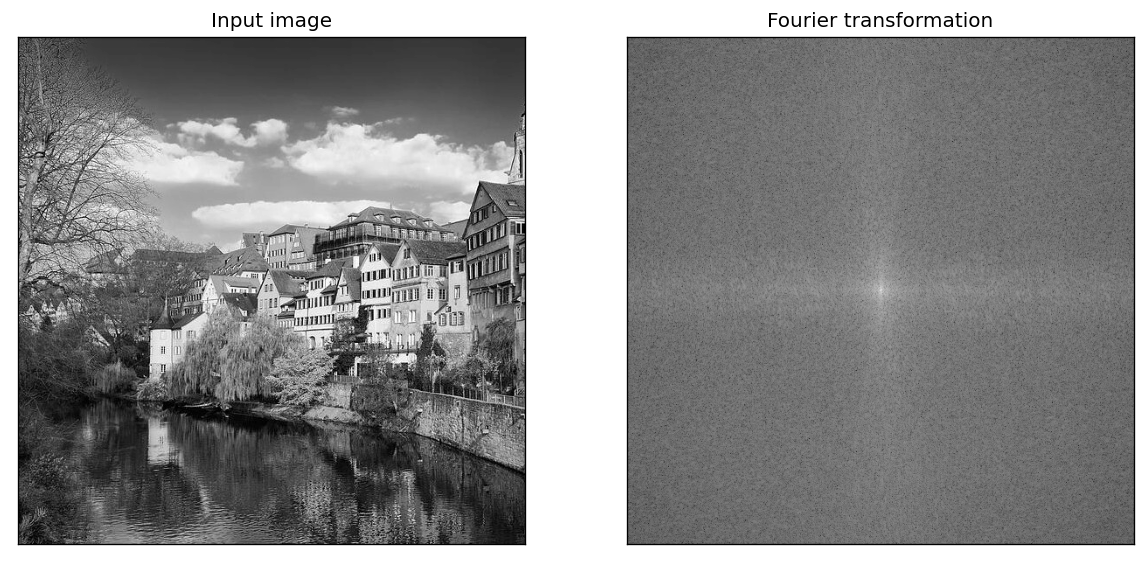

In [58]:
# ----- load the input image

img = imread('inputs/tuebingen.jpg')[:, :, 1] / 255.  
img_size = img.shape[0]


# TODO
FT_img = fft.fft2(img, s=None, axes=(-2, -1), norm=None, overwrite_x=False, workers=None, plan=None)
FT_img_freq = fft.fftshift(FT_img, axes=None) # SHIFT to frequencies
FT_img_abs = np.abs(FT_img_freq)

## absolute number needed to get magnitude from complex number

# ----- plot input image together with fourier transformation
if PLOT_RESULTS:   #plot_results:
    plt.figure(figsize=(12, 12),dpi=DPI)
    plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(img, cmap = 'gray')
    plt.title('Input image')

    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.log10(FT_img_abs), cmap='gray') ## smaller values result in more contrast
    plt.title('Fourier transformation')
    plt.show()


## 1.2 High-pass filter in spectral space

[[-21.73014121 -0.83112848j -12.10816004-19.45988424j
    2.35512948-26.20189581j ...  -6.8563048  -6.51838586j
   -9.71542862 +1.02013556j  35.70427165 -3.77959944j]
 [-14.77334026 +9.38892814j  -6.73553149 +8.14007805j
   17.16315968+30.53491991j ...  31.40064212 -4.06780208j
   16.09285015-12.76502526j -39.54215366-16.5968614j ]
 [-12.91293417 -5.2800612j   -2.84407771-13.62236503j
  -10.41615215-11.23556539j ... -24.60638188+16.32360066j
  -41.23193927 +6.20296679j   9.85108736+18.7431328j ]
 ...
 [  9.85108736-18.7431328j  -41.23193927 -6.20296679j
  -24.60638188-16.32360066j ... -10.41615215+11.23556539j
   -2.84407771+13.62236503j -12.91293417 +5.2800612j ]
 [-39.54215366+16.5968614j   16.09285015+12.76502526j
   31.40064212 +4.06780208j ...  17.16315968-30.53491991j
   -6.73553149 -8.14007805j -14.77334026 -9.38892814j]
 [ 35.70427165 +3.77959944j  -9.71542862 -1.02013556j
   -6.8563048  +6.51838586j ...   2.35512948+26.20189581j
  -12.10816004+19.45988424j -21.73014121 +0.8311

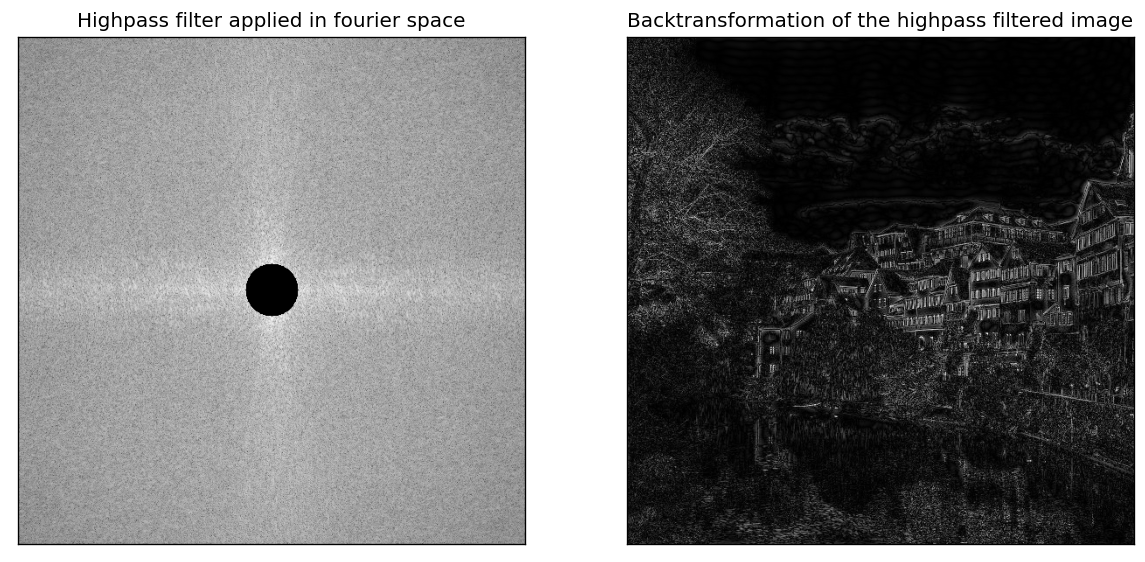

In [59]:
# TODO
def highpass_filter(img_size, radius):
    
    ''' Returns a highpass filter.
    input:
        img_size: length of the filter
        redius: radius of the circular aperture
    output:
        highpass: a filter of size(img_size, img_size) with values zero and one
    '''
    
    highpass = np.zeros((img_size, img_size))
    for i in range(img_size):
        for j in range(img_size):
            D = np.sqrt((i - (img_size//2))**2 + (j - (img_size//2))**2)
            if D <= radius:
                pass
            else:
                highpass[i,j] = 1
                
    return highpass

# TODO
#   step 2: apply filter (with radius 30) to the spectrum
highpass = highpass_filter(img_size, radius=RADIUS) 
img_highpass = FT_img_freq * highpass

print(img_highpass)
#print(FT_img_freq)


# TODO
#   step 3: transform the spectrum back to image space                     
img_filtered = fft.ifft2(img_highpass)

if PLOT_RESULTS:   #plot_results:
    plt.figure(figsize=(12, 12),dpi=DPI)
    plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.abs(img_highpass)**0.15, cmap = 'gray')   # Potenz dient der Kontrastanpassung
    plt.title('Highpass filter applied in fourier space')


    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow(abs(img_filtered), cmap=plt.cm.gray)
    plt.title('Backtransformation of the highpass filtered image')
    plt.show()
    
    

## 1.3 Gaussian filter

### 1.3.1 Construct a Gaussian filter

In [60]:
# TODO
def g_kern(kernlen=5, std=1):
    ''' Returns a 2D Gaussian kernel with standard devitation sig
    input:
        kernlen: length of the filter
        std: standard deviation of the gaussian in pixels
    output:
        g_kern_2d: a gaussian kernel of size (kernlen, kernlen) with sum 1
    '''
    g_kern_2d = np.zeros((kernlen, kernlen))
    for i in range(kernlen):
        for j in range(kernlen):
            dist = (i - (kernlen//2)) ** 2 + (j - (kernlen//2)) ** 2
            g_kern_2d[i, j] = stats.norm.pdf(np.sqrt(dist), scale=std) # to calculate the weights, we should use norm.pdf instead of norm.cdf
            
    # g_kern_2d = (1/np.sum(g_kern_2d)) * g_kern_2d # should i use this?
    return g_kern_2d

### 1.3.2 Apply Gaussian filter in image space

In [61]:
# TODO
#   step 2: create such a gaussian filter with standard deviation 3 and filtersize 25 and
#           convolve the image with this filter 
gaussfilter_img = g_kern(img_size, std=5)
img_conv = ndimage.convolve(img, g_kern(30,5))


### 1.3.3 Transform the Gaussian filter to fourier space

In [62]:
# TODO
#   step 3: transform the gaussian kernel to fourier space
gaussfilter_f = fft.fft2(gaussfilter_img)
gaussfilter_f_shift = fft.fftshift(gaussfilter_f)

### 1.3.4 Apply this filter in fourier space

In [63]:
f_gauss = abs(gaussfilter_f) * FT_img
img_gauss_f = fft.ifft2(f_gauss)

### 1.3.5. Visuallise and compare two filtering methods

difference: 0.053316343681112835


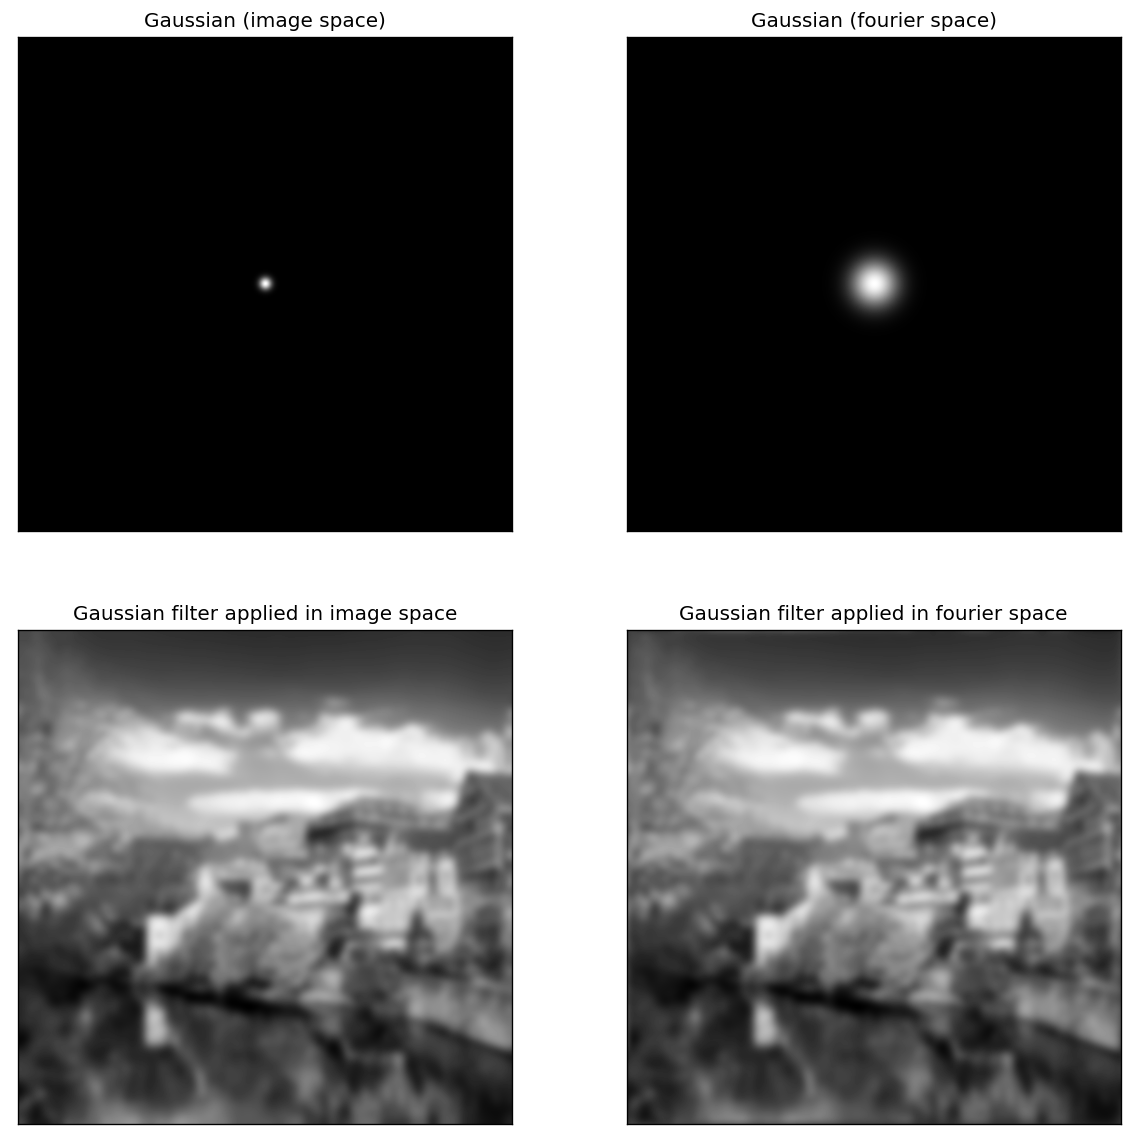

In [64]:
#   step 5: compare the results
difference = np.mean(np.abs(img_gauss_f - img_conv))       
print('difference: ' + str(difference))

if PLOT_RESULTS:
    # compare the two images
    plt.figure(figsize=(12, 12),dpi=DPI)

    plt.subplot(221)        # plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow((gaussfilter_img), cmap=plt.cm.gray)
    plt.title('Gaussian (image space)')
    plt.subplot(222)        # plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.abs(gaussfilter_f_shift), cmap=plt.cm.gray)
    plt.title('Gaussian (fourier space)')
    plt.subplot(223)        # plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_conv), cmap=plt.cm.gray)      # img_conv
    plt.title('Gaussian filter applied in image space')
    plt.subplot(224)        # plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(abs(img_gauss_f), cmap=plt.cm.gray)
    plt.title('Gaussian filter applied in fourier space')
    plt.show()


### 1.3.6 Splitted convolutional filter

TypeError: Image data of dtype object cannot be converted to float

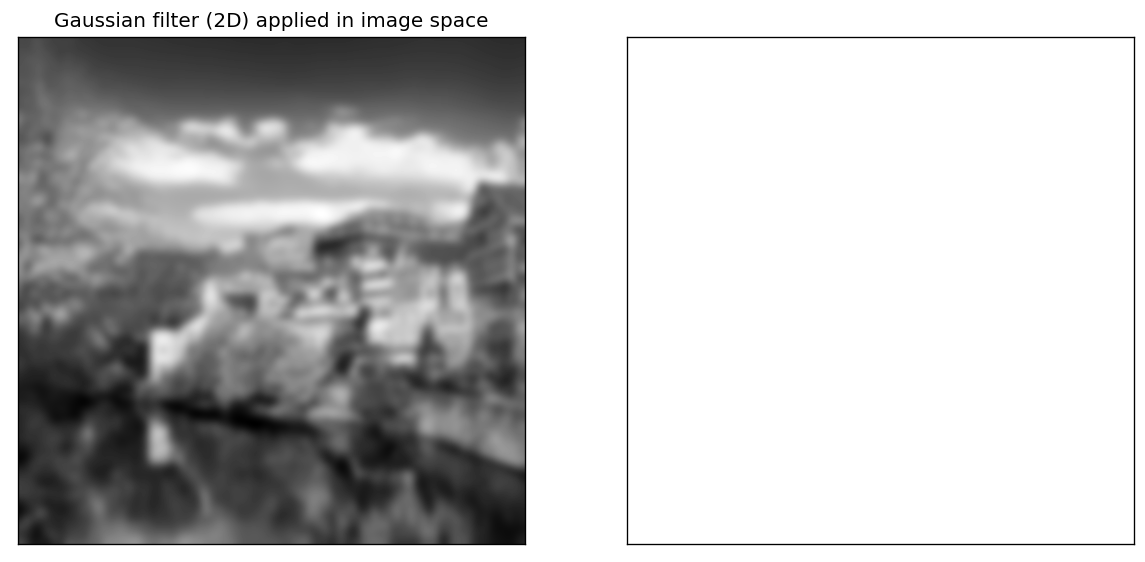

In [65]:
# TODO
def g_kern1d(kernlen=5, std=1):
    '''
    Returns a 1D Gaussian kernel with standard devitation sig 
    input:
        kernlen: length of the filter std: standard deviation of the gaussian in  pixels 
    output: 
        g_kern_1d: a gaussian kernel of size (kernlen, 1)
    '''
    g_kern_1d = ... 
    return g_kern_1d

gaussfilter_img_1D = ...
img_conv_sep_final = ...

# ----- plot results
if PLOT_RESULTS:   #plot_results:
    plt.figure(figsize=(12, 12),dpi=DPI)
    plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_conv), cmap=plt.cm.gray)      
    plt.title('Gaussian filter (2D) applied in image space')
    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow(img_conv_sep_final, cmap='gray')
    plt.title('Gaussian filter (separated) applied in image space')
    plt.show()